# Analysis of 2D-IR spectroscopy
This first cell loads the packages and code that are required.

In [1]:
%matplotlib inline
from ipywidgets import *
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

from util import *
from analysis import *
import fits
from plot import *
from plot3d import *

## Sample Dataset
The sample dataset here contains experimental 2D-IR spectra taken by the [Khalil group](http://sites.google.com/a/uw.edu/khalilgroup/) for the N-O stretch of sodium nitroprusside in a variety of solvents. These data are published in [_J Phys. Chem. A_ __2013__, _117_, 6234-6243](http://dx.doi.org/10.1021/jp4005345). The following is a list of names and the abbreviations used here:
- 'D2O'  (deuterium oxide/deuterated water)
- 'DMSO' (dimethyl sulfoxide)
- 'EG' (ethylene glycol)
- 'EtOH' (ethanol)
- 'FA' (formamide)
- 'H2O' (water)
- 'MeOH' (methanol)

The SOLVENT_NAME variable below can be modified to load data from a different solvent.

In [2]:
SOLVENT_NAME = 'H2O'
data,w1,w3,tau2 = loadSolvent(SOLVENT_NAME)

## Plotting the Original Data
The original data is 4-dimensional, with two frequency axes, intensity, and time.
Below one can view the data as a sequence of surfaces in time.  Due to computational considerations,
it is necessary to use the  ``update3d `` button to show the surface for a new time.

In [3]:
%matplotlib
%matplotlib notebook
def update3d(TimePoint=1):
    plt.close()
    my_fig = plt.figure(figsize=(9,5),num=SOLVENT_NAME)
    ax = surf3d(w1,w3,data[:,:,TimePoint],window_title=SOLVENT_NAME,ax_title='Time: '+str(tau2[TimePoint,0])+' fs',fig=my_fig,azim=azim,elev=elev)

azim = -50
elev = 30
interact_manual(update3d,TimePoint=IntSlider(min=0,max=len(tau2)))

Using matplotlib backend: Qt5Agg


<function __main__.update3d>

Single images at any time point can also be plotted.

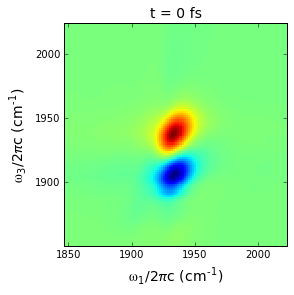

In [4]:
TIME_FS = 0
%matplotlib inline
show_data(data, w1, w3, tau2, TIME_FS)

A set of 3 images at different time points can be plotted.

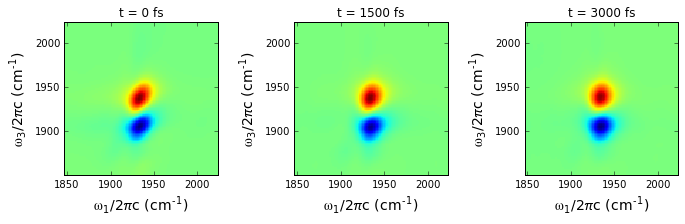

In [5]:
TIMES_FS = [0, 1500, 5000]
%matplotlib inline
show_3_data(data, w1, w3, tau2, TIMES_FS)

##  Performing Decompositions
A variety of decompositions of the data are possible. Here the PCA is explored. Both the `NORMALIZE` and `N_COMPONENTS` variables can be changed to affect the behavior. `NORMALIZE` changes whether the images in the set are normalized prior to performing PCA. Without normalization, the first PCA component tends to reflect the peak intensity; with normalization, all of the components relate to the peak shape. `N_COMPONENTS` represents the number of components used in the decomposition.

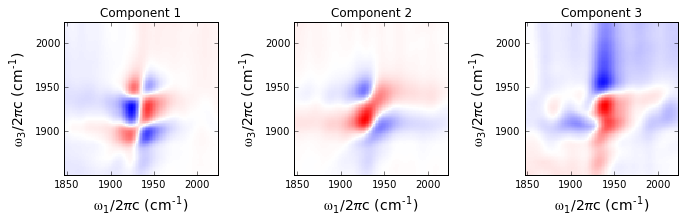

In [6]:
NORMALIZE = True
N_COMPONENTS = 10
ANALYSIS_TYPE = 'pca'  # 'pca', 'fa', or 'ica'
comp = get_components(data, normalize=NORMALIZE, n_comp=N_COMPONENTS, analysis_type=ANALYSIS_TYPE)
proj = get_projections(data, normalize=NORMALIZE, n_comp=N_COMPONENTS, analysis_type=ANALYSIS_TYPE)
%matplotlib inline
show_3_components(comp, w1, w3)

Individual components can also be visualized.

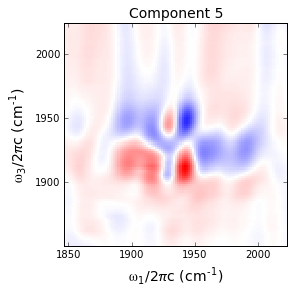

In [7]:
SELECTED_COMPONENT = 5
%matplotlib inline
show_component(comp, w1, w3, SELECTED_COMPONENT)

Three selected components can be visualized using the parameter `COMPS`, a list of components.

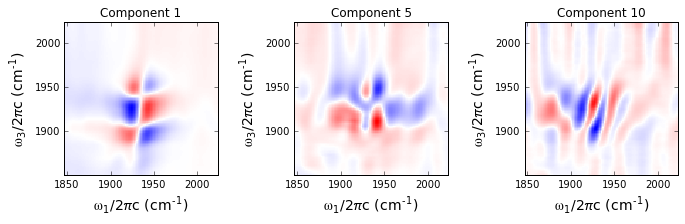

In [8]:
SELECTED_COMPONENTS = [1, 5, 10]
%matplotlib inline
show_3_components(comp, w1, w3, SELECTED_COMPONENTS)

## Components in Time
The time variation of the components provide information about how different modes are involved in the dynamics of the system.

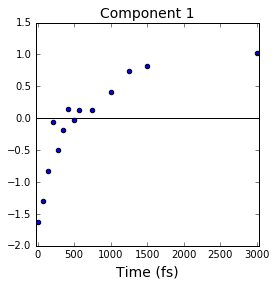

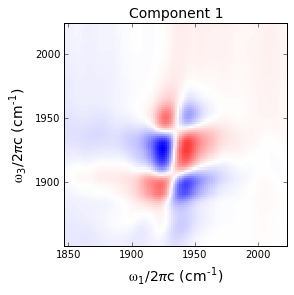

In [9]:
SELECTED_COMPONENT = 1
%matplotlib inline
show_contribution(tau2,proj,SELECTED_COMPONENT)
show_component(comp,w1,w3,SELECTED_COMPONENT)

## Curve Fitting
Now that we have time series data for each component we can use standard curve fits for linear and non-linear functions to estimate parameters such as time constants. The `COMP` parameter selects which component to use, and the `T_SCALE` parameter provides the units of the time (tau2) variable in fs. Thus a value of 1000 will correspond to ps. *Adjusting this parameter is sometimes necessary to avoid underflow or overflow conditions.* The `p0` variable is used to specify the initial guess for a non-linear fit, and can be adjusted if the fit results are not satisfactory.

The list of non-linear fits available here are:
- single exponential  ... $A e^{-Bt} + C$
- double exponential  ... $A_1 e^{-B_1t} + A_2 e^{-B_2t} + C$
- sine .... $A \sin(Bt) + C$

For the exponential decays, the relevant parameter is the characteristic decay time, given by 1/B. Single- and double-exponential fits of the first component's dynamics are shown below.

Decay time: 0.431222877397 ps


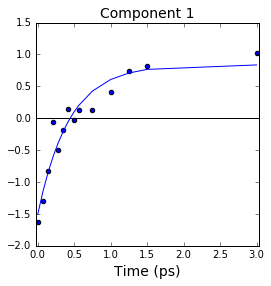

In [10]:
SELECTED_COMPONENT = 1
T_SCALE = 1000

p0 = np.abs(proj[0,SELECTED_COMPONENT-1] - proj[-1,SELECTED_COMPONENT-1]), 1, proj[-1,SELECTED_COMPONENT-1]  # initial guess
popt, pcov = curve_fit(fits.my_exponential, tau2.ravel()*(1/T_SCALE), proj[:,SELECTED_COMPONENT-1], p0, maxfev=1000)
#print('A='+str(popt[0]))
#print('B='+str(popt[1]))
#print('C='+str(popt[2]))
#print()
print("Decay time: " + str(1/popt[1]) + " ps")

%matplotlib inline
show_exp_fit(tau2, proj, SELECTED_COMPONENT, popt, T_SCALE)

Decay time 1: 1.11260697972 ps
Decay time 2: 0.131712410602 ps


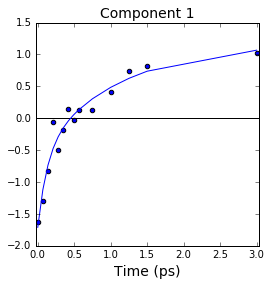

In [11]:
SELECTED_COMPONENT = 1
T_SCALE = 1000

p0 = 1, 1, 1, 1, 1  # initial guess
popt, pcov = curve_fit(fits.my_double_exp, tau2.ravel()*(1/T_SCALE), proj[:,SELECTED_COMPONENT-1], p0, maxfev=1000)
print("Decay time 1: " + str(1/popt[2]) + " ps")
print("Decay time 2: " + str(1/popt[3]) + " ps")

%matplotlib inline
show_exp_fit(tau2, proj, SELECTED_COMPONENT, popt, T_SCALE)

### End of Notebook

In [12]:
#reset the pyplot backend
%matplotlib
%matplotlib notebook

Using matplotlib backend: Qt5Agg
